In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple

import sys
import os

# Adjust this path if necessary to point to your src directory
src_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))
if src_path not in sys.path:
    sys.path.insert(0, src_path)


from gratis_precip.features import (
    LengthFeature,
    ACFFeature,
    EntropyFeature,
    TrendFeature,
    SeasonalStrengthFeature,
    NonlinearityFeature,
    HurstFeature,
    StabilityFeature,
    LumpinessFeature,
    TotalPrecipitation,
    PrecipitationIntensity,
    DrySpellDuration,
    WetSpellDuration,
    PrecipitationVariability,
    ExtremePrecipitationFrequency,
    MaximumDailyPrecipitation,
    WetDayFrequency,
)
from gratis_precip.dimensionality_reduction import DimensionalityReducer, TSNEReduction, PCAReduction

In [10]:
# Load the precipitation data
df = pd.read_csv("/Users/cooper/Desktop/gratis-precip/data/GSTEIGmeteo copy.csv")
precipitation = df["P_mix"].values


In [11]:
def split_into_seasons(
    precipitation: np.ndarray, days_per_season: int = 90
) -> Tuple[List[np.ndarray], List[str]]:
    """
    Split a long precipitation time series into seasonal segments.

    Args:
        precipitation (np.ndarray): The full precipitation time series.
        days_per_season (int): Number of days to consider for each season.

    Returns:
        Tuple[List[np.ndarray], List[str]]: List of seasonal segments and their corresponding season labels.
    """
    segments = []
    labels = []
    seasons = ["Winter", "Spring", "Summer", "Autumn"]

    for i in range(0, len(precipitation) - days_per_season + 1, days_per_season):
        segment = precipitation[i : i + days_per_season]
        segments.append(segment)
        labels.append(seasons[(i // days_per_season) % 4])

    return segments, labels


def classify_seasons(segments: List[np.ndarray], labels: List[str]) -> List[str]:
    """
    Classify seasons as 'Dry' or 'Wet' based on total precipitation.

    Args:
        segments (List[np.ndarray]): List of seasonal precipitation segments.
        labels (List[str]): List of corresponding season labels.

    Returns:
        List[str]: List of classified season labels.
    """
    totals = [np.sum(segment) for segment in segments]
    median = np.median(totals)

    classified_labels = []
    for total, label in zip(totals, labels):
        if total < median:
            classified_labels.append(f"Dry {label}")
        else:
            classified_labels.append(f"Wet {label}")

    return classified_labels

In [12]:
# Split the precipitation data into seasonal segments
segments, season_labels = split_into_seasons(precipitation)

# Classify the seasons
classified_labels = classify_seasons(segments, season_labels)

In [13]:
# Create a FeatureExtractor with both base and precipitation-specific features
class FeatureExtractor:
    def __init__(self, features):
        self.features = features

    def extract_features(self, time_series):
        return {
            feature.__class__.__name__: feature.calculate(time_series)
            for feature in self.features
        }

    def extract_feature_matrix(self, time_series_list):
        feature_matrix = []
        for ts in time_series_list:
            features = self.extract_features(ts)
            feature_vector = []
            for value in features.values():
                if isinstance(value, (list, np.ndarray)):
                    feature_vector.extend(value)
                else:
                    feature_vector.append(value)
            feature_matrix.append(feature_vector)
        return np.array(feature_matrix)

In [23]:
extractor = FeatureExtractor(
    [
        # LengthFeature(),
        # ACFFeature(),
        # EntropyFeature(),
        # TrendFeature(),
        # SeasonalStrengthFeature(),
        # NonlinearityFeature(),
        # HurstFeature(),
        # StabilityFeature(),
        # LumpinessFeature(),
        TotalPrecipitation(),
        PrecipitationIntensity(),
        DrySpellDuration(),
        WetSpellDuration(),
        PrecipitationVariability(),
        ExtremePrecipitationFrequency(),
        MaximumDailyPrecipitation(),
        WetDayFrequency(),
    ]
)

# Extract features for all segments
feature_matrix = extractor.extract_feature_matrix(segments)
print(f"Feature matrix shape: {feature_matrix.shape}")



Feature matrix shape: (59, 8)


In [27]:
# Perform dimensionality reduction
reducer = DimensionalityReducer(PCAReduction())
projection = reducer.reduce_dimensions(feature_matrix)

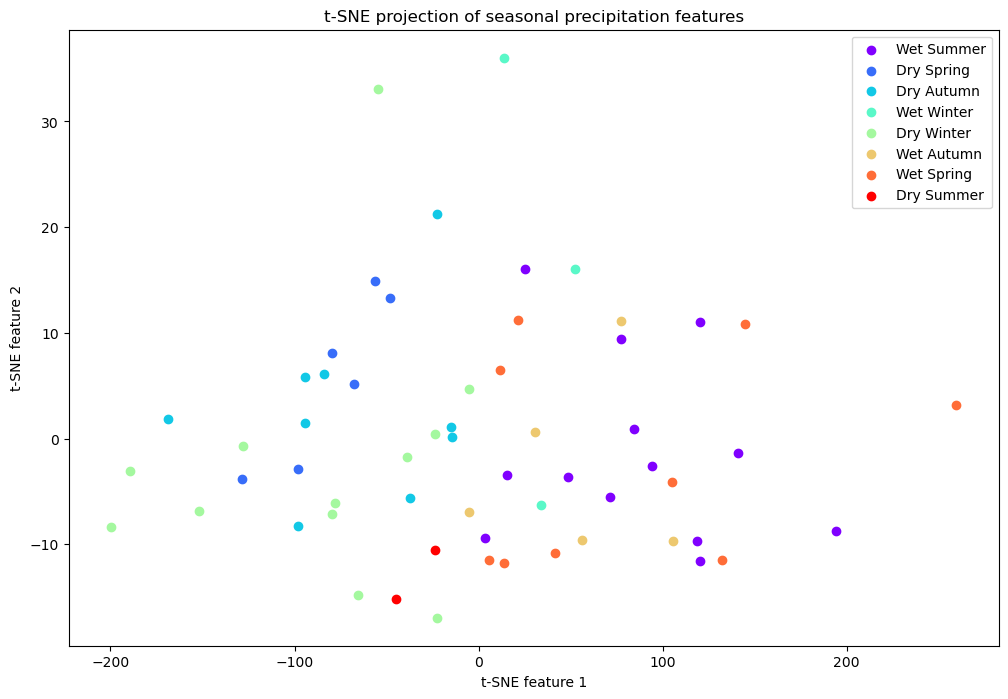

In [28]:
# Visualize the projection
plt.figure(figsize=(12, 8))

unique_labels = list(set(classified_labels))
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(unique_labels, colors):
    mask = np.array(classified_labels) == label
    plt.scatter(projection[mask, 0], projection[mask, 1], label=label, color=color)

plt.title("t-SNE projection of seasonal precipitation features")
plt.xlabel("t-SNE feature 1")
plt.ylabel("t-SNE feature 2")
plt.legend()
plt.show()

In [22]:
# Print some statistics
for season in set(classified_labels):
    season_data = [
        seg for seg, label in zip(segments, classified_labels) if label == season
    ]
    print(f"\n{season} statistics:")
    print(
        f"  Average daily precipitation: {np.mean([np.mean(seg) for seg in season_data]):.2f}"
    )
    print(
        f"  Total seasonal precipitation: {np.mean([np.sum(seg) for seg in season_data]):.2f}"
    )
    print(
        f"  Maximum daily precipitation: {np.max([np.max(seg) for seg in season_data]):.2f}"
    )


Wet Summer statistics:
  Average daily precipitation: 4.87
  Total seasonal precipitation: 437.85
  Maximum daily precipitation: 53.80

Dry Spring statistics:
  Average daily precipitation: 3.03
  Total seasonal precipitation: 272.27
  Maximum daily precipitation: 50.20

Dry Autumn statistics:
  Average daily precipitation: 3.14
  Total seasonal precipitation: 282.18
  Maximum daily precipitation: 57.60

Wet Winter statistics:
  Average daily precipitation: 4.28
  Total seasonal precipitation: 384.80
  Maximum daily precipitation: 73.00

Dry Winter statistics:
  Average daily precipitation: 2.95
  Total seasonal precipitation: 265.73
  Maximum daily precipitation: 68.10

Wet Autumn statistics:
  Average daily precipitation: 4.50
  Total seasonal precipitation: 405.08
  Maximum daily precipitation: 50.60

Wet Spring statistics:
  Average daily precipitation: 4.82
  Total seasonal precipitation: 433.88
  Maximum daily precipitation: 52.50

Dry Summer statistics:
  Average daily precipit